# Advanced Risk Management - Assignment 2

## Monte Carlo approach to Value at Risk computation

### Prepared by Deloitte – Financial Risk Management

**Deadline**:  March 13, 23.59h.

| |Name |Student number|Email|

|1.| Jason Spano | 12792160   | jason.spano@student.uva.nl    |

****Hand in the following via Canvas****:
* Your notebook.
* A (printed) pdf version of your notebook. In Google Colab, this is most conveniently done in the Chrome browser, and then using the **`File` -> `Print`** menu option; you may have to print in landscape mode to make sure that everything appears in the pdf.

****Notes****:
* The assignment is part of the examination, so the usual rules regarding plagiarism and fraud apply.
* Before submitting your work, click on **`Runtime`-> `Restart and run all ...`** and verify that your notebook produces the desired results and does not error.

**Declaration of Originality**: We whose names are given under 1. above declare that these solutions are solely our own work, and that we have not made these solutions available to any other student.

### Introduction
The data file `SPX&MSFT_1990-2020_USD.xlsx` contains daily price data (January 1990 – February 2020) on the closing price of the S&P 500 index and the Microsoft stock.

In [1]:
# Load libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from IPython.display import display_html
from arch import arch_model
from tabulate import tabulate 
from math import isclose
from scipy.stats import ttest_ind, ttest_rel, kendalltau, normaltest, pearsonr
from copulae import GaussianCopula, NormalCopula, StudentCopula

In [2]:
# Load data
df_main = pd.ExcelFile('SPX&MSFT_1990-2020_USD.xlsx')
df_spx = pd.read_excel(df_main, 'S&P500')
df_mfst = pd.read_excel(df_main, 'Microsoft')

In [3]:
#concatenate series and clean up index 
df_complete = pd.concat([df_mfst, df_spx], axis=1)
df_complete.columns = ['Date','MFST','DATE2','SPX']
df_complete = df_complete.drop(['DATE2'],axis=1)
df_complete.set_index('Date',inplace=True)
df_complete.head(5)

,MFST,SPX
Date,,
1990-01-02,0.6163,359.69
1990-01-03,0.6198,358.76
1990-01-04,0.6380,355.67
1990-01-05,0.6224,352.20
1990-01-08,0.6319,353.79


In [4]:
#Check data for NaN(s) 
df_complete.isnull().any()

MFST    False
SPX     False
dtype: bool

### Question 1
* Construct daily log-returns for the two price series; the return series of the S&P 500 is hereafter denoted by $R_{1t}$, and the return series of the Microsoft stock by $R_{2t}$.
* Present and describe / discuss the descriptive statistics (mean, standard deviation, skewness, kurtosis) of both return series.

In [5]:
#convert the concatenated dataframe to daily log-returns
df_comp_log = np.log(df_complete / df_complete.shift(1))

#remove 1990-01-02 observation as now NaN (1st location) 
df_comp_log = df_comp_log.dropna() 

## show head 
df_comp_log.head()

,MFST,SPX
Date,,
1990-01-03,0.005663,-0.002589
1990-01-04,0.028941,-0.008650
1990-01-05,-0.024755,-0.009804
1990-01-08,0.015148,0.004504
1990-01-09,-0.002694,-0.011857


In [6]:
#Summary Statistics 
stat = df_comp_log.describe()
stat.loc['skew'] = df_comp_log.skew().tolist()
stat.loc['kurt'] = df_comp_log.kurtosis().tolist()
print(stat)

              MFST          SPX
count  7593.000000  7593.000000
mean      0.000748     0.000294
std       0.019889     0.010969
min      -0.169578    -0.094695
25%      -0.009021    -0.004309
50%       0.000298     0.000545
75%       0.010474     0.005528
max       0.178692     0.109572
skew      0.007768    -0.267897
kurt      5.996909     8.870035


## Discussion:

* The table above shows the descriptive statistics of both the Microsoft and S&P 500 returns. It shows that the mean of returns for both of the assets is very close to zero. However, the standard deviation, skewness and kurtosis can provide more insight. Under normality, skewness should be 0 and kurtosis should be 3. In line with the stylsed facts of asset returns, these returns are not normally distributed measured at the daily level: note this would be they do not conform to the log-normal assumption as these are the logs of the returns. This is most prominent in the kurtosis, which explains the tails of the distribution adn measures the outliers present in the distribution. 
* Also notaworthy is that the volatility of Microsoft is almost twice as high as for S&P 500. This makes sense because the S&P 500 returns are a lot more diversified by being the index, which is in itself a diversified portfolio of different stocks that also includes Microsoft
* The table shows that the S&P 500 returns are (moderately) negatively skewed, meaning that negative returns are more likely to happen than positive returns. Microsoft's skewness is close to zero, so fairly neglectible. Furthermore, S&P 500 has higher kurtosis than Microsoft. This means that the S&P 500 return distribution is more heavy-tailed than Microsoft's distribution. Both have a kurtosis higher than the kurtosis of 3, meaning they are more heavy-tailed than normal the distribution. Once again, this is not surprising as stock returns are known to be non-normal.

*  Considering the results from 1., fit an appropriate probability distribution 𝐹1 and 𝐹2 to the standardized daily log returns of both return series. For fitting the distribution you may consider the Python package ‘Scipy.stats’. Alternatively, minimize the distance between the empirical CDF of 𝑅1𝑡 and 𝑅2𝑡, and the CDF of the fitted distributions 𝐹1 and 𝐹2 by optimizing the parameters of the distributions. Elaborate on your choice of distribution. 
 
* Plot the results, comparing the fitted cumulative distribution function of the distributions with the empirical cumulative distribution function of both return series. 

### Question 2
* Considering the results from Question 1, fit appropriate probability distributions $F_1$ and $F_2$ to both daily log returns series. For fitting the distribution, you may consider the Python package `scipy.stats`. Alternatively, minimize the distance between the empirical CDF of $𝑅_{1𝑡}$ and $𝑅_{2𝑡}$, and the CDF of the fitted distributions $𝐹_1$ and $𝐹_2$ by optimizing the parameters of the distributions. Elaborate on your choice of distribution.
* Plot the results, comparing the fitted cumulative distribution functions of the Normal distributions with the empirical cumulative distribution function of both return series.

In [7]:
#define log series names 
lret_mfst = df_comp_log['MFST']
lret_spx = df_comp_log['SPX']

### MFST 

C:\Users\jason\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


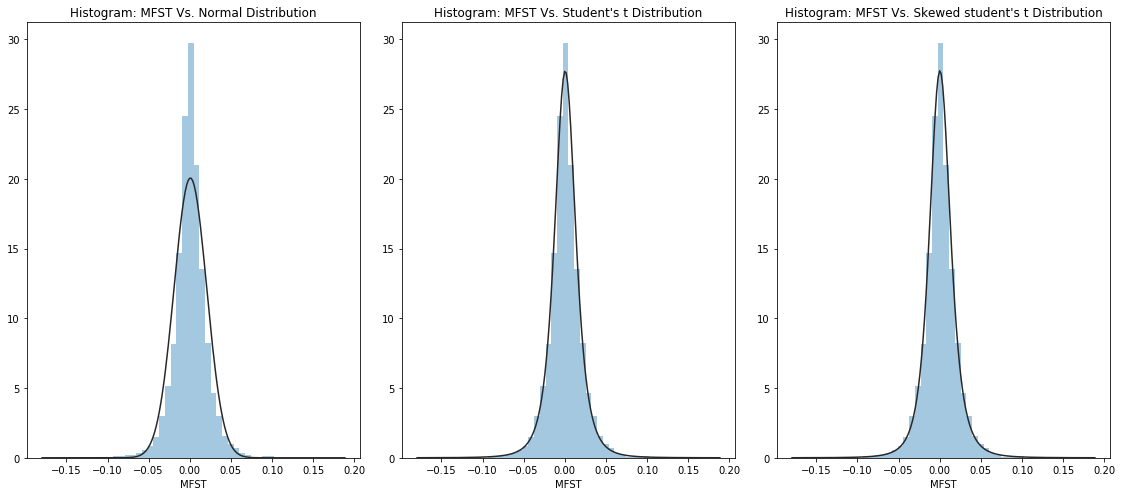

In [8]:
## MFST Distribution Histograms 
## KDE = False, fits are: normal, student's-t distribution and skewed student's t-dist 
fig, ax, = plt.subplots(ncols=3,figsize=(16,7))

sns.distplot(lret_mfst, kde=False, fit=stats.norm,ax=ax[0])
ax[0].set_title('Histogram: MFST Vs. Normal Distribution')

sns.distplot(lret_mfst, kde=False, fit=stats.t,ax=ax[1])
ax[1].set_title("Histogram: MFST Vs. Student's t Distribution")

sns.distplot(lret_mfst, kde=False, fit=stats.nct,ax=ax[2])
ax[2].set_title("Histogram: MFST Vs. Skewed student's t Distribution")

plt.tight_layout()

#### SPX
* Repeat for index series

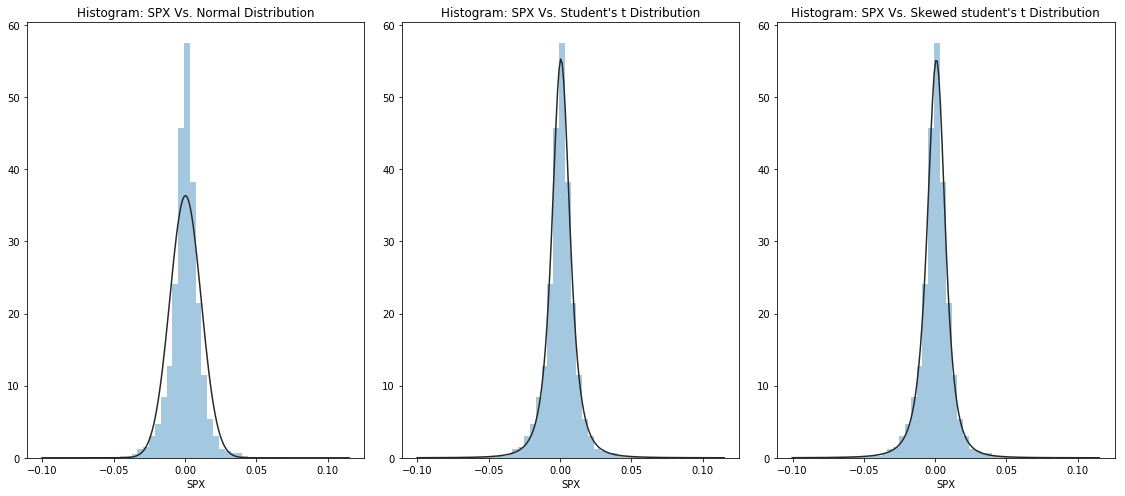

In [9]:
## SPX Distribution Histograms 
fig, ax, = plt.subplots(ncols=3,figsize=(16,7))
sns.distplot(lret_spx, kde=False, fit=stats.norm,ax=ax[0])
ax[0].set_title('Histogram: SPX Vs. Normal Distribution')
sns.distplot(lret_spx, kde=False, fit=stats.t,ax=ax[1])
ax[1].set_title("Histogram: SPX Vs. Student's t Distribution")
sns.distplot(lret_spx, kde=False, fit=stats.nct,ax=ax[2])
ax[2].set_title("Histogram: SPX Vs. Skewed student's t Distribution")
plt.tight_layout()

### MFST QQ PLOTS

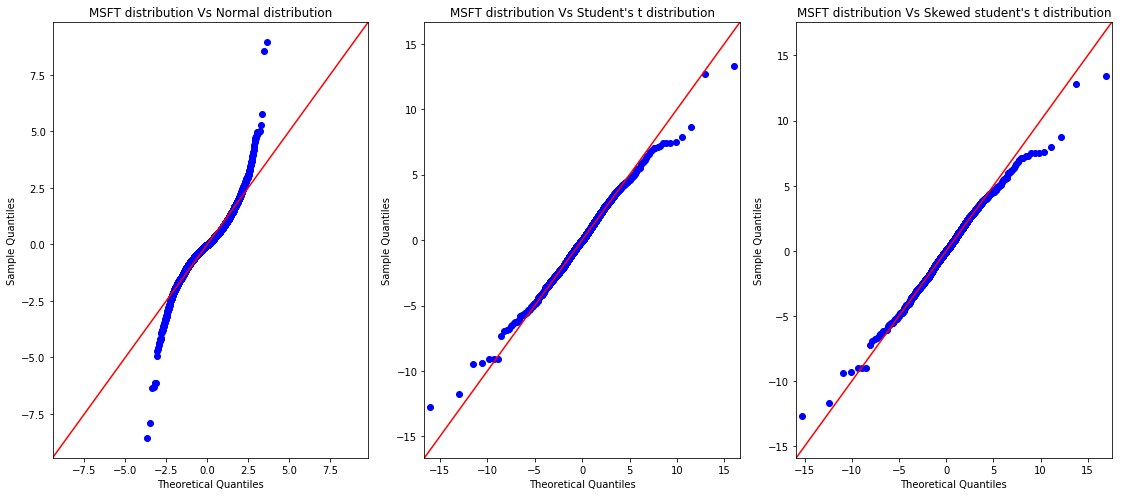

In [10]:
#MFST QQ Plots 
fig, ax, = plt.subplots(ncols=3,figsize=(16,7))
sm.qqplot(lret_mfst, dist=stats.norm, fit=True, line='45',ax=ax[0])
ax[0].set_title('MSFT distribution Vs Normal distribution')
sm.qqplot(lret_mfst, dist=stats.t, fit=True, line='45',ax=ax[1])
ax[1].set_title("MSFT distribution Vs Student's t distribution")
sm.qqplot(lret_mfst, dist=stats.nct, fit=True, line='45',ax=ax[2])
ax[2].set_title("MSFT distribution Vs Skewed student's t distribution")
plt.tight_layout()

### SPX QQ PLOTS

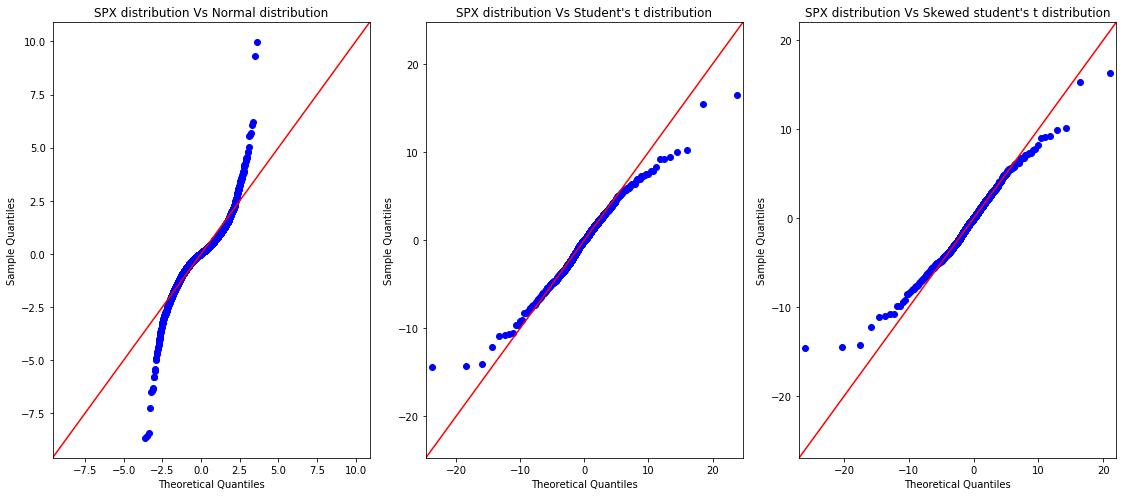

In [11]:
#SPX QQ Plots 
fig, ax, = plt.subplots(ncols=3,figsize=(16,7))
sm.qqplot(lret_spx, dist=stats.norm, fit=True, line='45',ax=ax[0])
ax[0].set_title('SPX distribution Vs Normal distribution')
sm.qqplot(lret_spx, dist=stats.t, fit=True, line='45',ax=ax[1])
ax[1].set_title("SPX distribution Vs Student's t distribution")
sm.qqplot(lret_spx, dist=stats.nct, fit=True, line='45',ax=ax[2])
ax[2].set_title("SPX distribution Vs Skewed student's t distribution")
plt.tight_layout()

In [12]:
#Normality test (skewness and kurtosis matching a normal distribution) for Microsoft returns:
stat_mfst, p_mfst = stats.jarque_bera(lret_mfst) 
print('stat=%.3f, p=%.3f' % (stat_mfst, p_mfst))

## check the p-value on the statistic
if p_mfst > 0.05:
 print('MFST: Assumed to be Gaussian/Normal')
else:
 print('MFST: Assumed to not be Gaussian/Normal')
#stats.jarque_bera(lret_mfst) 

stat=11359.873, p=0.000
MFST: Assumed to not be Gaussian/Normal


In [13]:
#Normality test (skewness and kurtosis matching a normal distribution) for SPX returns:
stat_spx, p_spx = stats.jarque_bera(lret_spx) 
print('stat=%.3f, p=%.3f' % (stat_spx, p_spx))
if p_spx > 0.05:
 print('SPX: Assumed to be Gaussian/Normal')
else:
 print('SPX: Assumed to not be Gaussian/Normal')

stat=24945.189, p=0.000
SPX: Assumed to not be Gaussian/Normal


## Discussion Question 2:

1. To see what distribution would fit the data best, we first visualize the distributions by a histogram and QQ-plot. We see that for Microsoft that the normal distribution does not fit well. The histogram shows that the return distribution is more sharply peaked than for a normal distribution and the QQ-plot shows that its tails are also more heavy than in a normal distribution would be. We find the same results for the S&P 500 return distribution. When we visualize the data against a skewed t-distribution, we see two things. For Microsoft we see through the QQ-plot that it fits the left tail better, but the left tail worse compared to standard student's t distribution. For the S&P 500 data we see exactly the opposite. A skewed sudent's t distribution has therefore no additional value and we choose between the normal and standard student's t distribution.

* We test for normality of the data by using a Jarque-Bera test and find that the Null hypothesis is rejected for both assets. This means normality is rejected and we therefore based off the two methods, choose to fit the data with a t-distribution.


### Question 3
Assume you have a portfolio with equal weights in both the index and the stock.
* Determine the sample correlation between the two return series based on the data.
* Use the copula function of the Normal distribution to generate 50,000 correlated pairs $(u_{1i},u_{2i}), i=1,\ldots,50,000$, from the uniform (copula) distribution  using the calculated correlation coefficient (for this, you may use Python packages such as `Copulae` or `PyCopula`). 
* Transform the uniform numbers generated by the copula function to returns using the inverse of the fitted cumulative distribution functions $F_1$ and $F_2$.
* Determine the 1-day 1% Value at Risk of the portfolio.
* Next, consider the index and stock on a standalone basis. Calculate the 1-day 1% Value at Risk using 50,000 simulated returns for both the S&P 500 and the stock. What is the impact of diversification in this portfolio? This can be examined by calculating the 1-day 1% VaR of the single return series, and comparing with the 1-day 1% VaR of the combined portfolio.

#### Step 1: Fit a GARCH model for the standardised shocks

In [14]:
#Fitting a normal GARCH
#MFST
returns_mfst = df_comp_log['MFST'] * 100   #using the log but *100

## fit the arch model
arch_1 = arch_model(returns_mfst, 
                    vol='Garch',
                    p=1,o=0,q=1, 
                    dist='Normal')

arch1_res = arch_1.fit()

## define the residual / conditional volatility and standardised shocks series respectively
arch_1_res = arch1_res.resid
arch_1_hsq = arch1_res.conditional_volatility
mfst_arch_1_zt = returns_mfst / arch_1_hsq

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15189.720576479187
Iteration:      2,   Func. Count:     17,   Neg. LLF: 15180.153360437855
Iteration:      3,   Func. Count:     27,   Neg. LLF: 15180.07797193695
Iteration:      4,   Func. Count:     37,   Neg. LLF: 15180.069841305078
Iteration:      5,   Func. Count:     44,   Neg. LLF: 15177.447715396185
Iteration:      6,   Func. Count:     51,   Neg. LLF: 15175.79875118812
Iteration:      7,   Func. Count:     58,   Neg. LLF: 15174.28401407324
Iteration:      8,   Func. Count:     65,   Neg. LLF: 15173.69979345532
Iteration:      9,   Func. Count:     71,   Neg. LLF: 15173.291621451037
Iteration:     10,   Func. Count:     77,   Neg. LLF: 15173.063195681436
Iteration:     11,   Func. Count:     83,   Neg. LLF: 15173.03572592825
Iteration:     12,   Func. Count:     89,   Neg. LLF: 15173.02984568741
Iteration:     13,   Func. Count:     95,   Neg. LLF: 15173.029721414168
Optimization terminated successfully.    (Exit mode 0)
  

In [15]:
## repeat for SPX
returns_spx = df_comp_log['SPX'] * 100   #using the log but *100

arch_2 = arch_model(returns_spx, 
                    vol='Garch',
                    p=1,o=0,q=1, 
                    dist='Normal')

arch2_res = arch_2.fit()
arch_2_res = arch2_res.resid
arch_2_hsq = arch2_res.conditional_volatility
spx_arch_2_zt = returns_spx / arch_2_hsq

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9926.284648599867
Iteration:      2,   Func. Count:     17,   Neg. LLF: 9920.7180749123
Iteration:      3,   Func. Count:     26,   Neg. LLF: 9917.242755746298
Iteration:      4,   Func. Count:     35,   Neg. LLF: 9917.152809178173
Iteration:      5,   Func. Count:     42,   Neg. LLF: 9913.99021972904
Iteration:      6,   Func. Count:     49,   Neg. LLF: 9912.572477413705
Iteration:      7,   Func. Count:     56,   Neg. LLF: 9911.49215156969
Iteration:      8,   Func. Count:     63,   Neg. LLF: 9911.286316474661
Iteration:      9,   Func. Count:     69,   Neg. LLF: 9911.109985057108
Iteration:     10,   Func. Count:     75,   Neg. LLF: 9910.810763432004
Iteration:     11,   Func. Count:     81,   Neg. LLF: 9910.80785792118
Iteration:     12,   Func. Count:     87,   Neg. LLF: 9910.80783781318
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9910.807837809405
            Iterations: 12
      

In [16]:
## zip together so that the shapes will fit for the copulae function
arch_zt_df = pd.DataFrame(list(zip(mfst_arch_1_zt, spx_arch_2_zt)),columns=['MFST','SPX'])

In [17]:
_, ndim = arch_zt_df.shape

## def dim = number of dimensions in the df.shape
g_cop_arch = GaussianCopula(dim=ndim)

## fit copulae model and show summary
g_cop_arch.fit(arch_zt_df)
g_cop_arch.summary()

Gaussian Copula Summary
================================================================================
Gaussian Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
 Correlation Matrix 
 1.000000  0.627855
 0.627855  1.000000



                                  Fit Summary                                   
================================================================================
Log. Likelihood      : -1898.3688741432595
Variance Estimate    : Not Implemented Yet
Method               : Maximum pseudo-likelihood
Data Points          : 7593

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(-1.0, 1.0)]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [0.62785452]
	fun            : -1898.3688741432595
	jac            : [-0.00180383]
	nit            : 4
	nfev           : 14
	njev           : 4
	status         : 0
	message        : Optimization terminated successfully.
	success        : True

In [18]:
arch_cop_params = g_cop_arch.params
arch_cop_params

array([0.62785452])

In [19]:
#check correlations 
## NOTE:  spearman correlation is non-parametric 
arch_zt_df_ken = arch_zt_df.corr(method='kendall')
arch_zt_df_pear = arch_zt_df.corr(method='pearson')
arch_zt_df_spear = arch_zt_df.corr(method='spearman')

In [20]:
#Test if correlation matches copula within 2.5% error margin 

if np.isclose(arch_cop_params[0], arch_zt_df_spear.iloc[0,1],rtol=0.025)== True:
    print("Copula Parameter approximately matches correlation implied by spearman correlation measure")
    
elif np.isclose(arch_cop_params[0], arch_zt_df_spear.iloc[0,1],rtol=0.025)!= True:
    print("Copula Parameter does not match correlation implied by Spearman")
    
if np.isclose(arch_cop_params[0], arch_zt_df_ken.iloc[0,1],rtol=0.025)== True:
    print("Copula Parameter approximately matches correlation implied by Kendall correlation measure")
    
elif np.isclose(arch_cop_params[0], arch_zt_df_ken.iloc[0,1],rtol=0.025)!= True:
    print("Copula Parameter does not match correlation implied by Kendall measure")
    
if np.isclose(arch_cop_params[0], arch_zt_df_pear.iloc[0,1],rtol=0.025)== True:
    print("Copula Parameter approximately matches correlation implied by Pearson correlation measure")
    
elif np.isclose(arch_cop_params[0], arch_zt_df_pear.iloc[0,1],rtol=0.025)!= True:
    print("Copula Parameter does not match correlation implied by Pearson measure")

Copula Parameter approximately matches correlation implied by spearman correlation measure
Copula Parameter does not match correlation implied by Kendall measure
Copula Parameter does not match correlation implied by Pearson measure


* The rejection of the pearson measure is consistent with our expectations as the two series have different respective variances
* The rejection of the Kendall measure (the statistic is used to measure ordinal association and is closest to 1 when the observations have similar or identical rank correlation) this would perhaps imply the degree of correlation isn't so extreme that it can't be better captured by another measure
* The matching implied by the spearman measure- a non-parametric measure of rank correlation- is consistent with some expected underlying notions of the data, such as:  monotonic relationship seems likely between the stock and its index- which is confirmed by the approximate match here. Additionally, unlike the pearson measure, there is no required linearity

In [21]:
## generate 50k random samples
copula_samples = g_cop_arch.random(50000)

In [22]:
#arch_ppf 
arch_ppf = g_cop_arch.pdf(copula_samples)

In [23]:
#arch_cdf
arch_cdf = g_cop_arch.cdf(copula_samples)

In [24]:
arch_norm_cdf = stats.norm.cdf(copula_samples)

In [25]:
arch_norm_ppf = stats.norm.ppf(arch_norm_cdf)

In [26]:
copula_norm = stats.norm.ppf(copula_samples)

In [27]:
#Weights: 50% equally 
weights = [[0.5],[0.5]]

In [28]:
#standard deviations of original returns (log)
stddev_mfst = np.std(df_comp_log['MFST'])
stddev_spx = np.std(df_comp_log['SPX'])
print(stddev_mfst, stddev_spx)

0.019887191374358414 0.010967799244958618


In [29]:
split_copnorm = pd.DataFrame(copula_norm)
split_copnorm.columns = ['MFST_1','SPX_1']

In [30]:
#Show easy summary, unsorted DataFrame
copnorm_vol_adj = split_copnorm
copnorm_vol_adj['MFST_STD_DEV'] = stddev_mfst
copnorm_vol_adj['SPX_STD_DEV'] = stddev_spx
copnorm_vol_adj['MFST_RET*VOL'] = stddev_mfst * split_copnorm['MFST_1']
copnorm_vol_adj['MFST_WEIGHT'] = 0.5
copnorm_vol_adj['SPX_RET*VOL'] = stddev_spx * split_copnorm['SPX_1']
copnorm_vol_adj['SPX_WEIGHT'] = 0.5
copnorm_vol_adj['PORTFOLIO_W_RET'] = (copnorm_vol_adj['MFST_WEIGHT'] * copnorm_vol_adj['MFST_RET*VOL']) + (copnorm_vol_adj['SPX_WEIGHT'] * copnorm_vol_adj['SPX_RET*VOL'])
copnorm_vol_adj.head()

,MFST_1,SPX_1,MFST_STD_DEV,SPX_STD_DEV,MFST_RET*VOL,MFST_WEIGHT,SPX_RET*VOL,SPX_WEIGHT,PORTFOLIO_W_RET
0,-0.380593,-0.587229,0.019887,0.010968,-0.007569,0.5,-0.006441,0.5,-0.007005
1,0.791014,1.467617,0.019887,0.010968,0.015731,0.5,0.016097,0.5,0.015914
2,-1.725969,-0.926056,0.019887,0.010968,-0.034325,0.5,-0.010157,0.5,-0.022241
3,-0.630032,0.624944,0.019887,0.010968,-0.012530,0.5,0.006854,0.5,-0.002838
4,-0.455691,-1.572006,0.019887,0.010968,-0.009062,0.5,-0.017241,0.5,-0.013152


In [31]:
#Sort data by portfolio weighted returns
sorted_cop_voladj = copnorm_vol_adj.sort_values(by='PORTFOLIO_W_RET',
                                                ascending=True)

sorted_cop_voladj.head()

,MFST_1,SPX_1,MFST_STD_DEV,SPX_STD_DEV,MFST_RET*VOL,MFST_WEIGHT,SPX_RET*VOL,SPX_WEIGHT,PORTFOLIO_W_RET
8766,-3.683671,-3.842959,0.019887,0.010968,-0.073258,0.5,-0.042149,0.5,-0.057703
23471,-4.177067,-2.293179,0.019887,0.010968,-0.083070,0.5,-0.025151,0.5,-0.054111
19226,-4.190814,-2.194233,0.019887,0.010968,-0.083344,0.5,-0.024066,0.5,-0.053705
23158,-4.008023,-2.207265,0.019887,0.010968,-0.079708,0.5,-0.024209,0.5,-0.051959
27401,-3.450878,-3.213647,0.019887,0.010968,-0.068628,0.5,-0.035247,0.5,-0.051937


# VaR
#### Different method comparisons 

In [32]:
#Historical Simulation for 99% Value At Risk
VaR_99 = -np.quantile(sorted_cop_voladj['PORTFOLIO_W_RET'], 0.01) 
VaR_99

0.03282091084373755

In [33]:
mean_pf = copnorm_vol_adj['PORTFOLIO_W_RET'].mean()
std_dev_pf = copnorm_vol_adj['PORTFOLIO_W_RET'].std()
VaR_99_normd = -stats.norm.ppf(1-0.99, mean_pf, std_dev_pf)
VaR_99_normd

0.032736263055182416

In [34]:
#Apply a 2nd method  to ensure the validity of the above VaR method
CV_99 = stats.norm.ppf(1-0.99)
VaR_portfolio = -mean_pf - std_dev_pf*CV_99
VaR_portfolio

0.032736263055182416


* Now we consider the index and the stocks on a standalone basis: 

In [35]:
#Student's T- MFST

## number of sims
n_sims = 50000

## degrees of freedom
DOF = 4

## define standard deviation
std_MFST = np.std(df_comp_log['MFST'])

## sim returns based off DOF and n_sims
sim_returns_MFST = np.random.standard_t(DOF, n_sims)

## calculated simulated student's-T VaR for MFST
SimVAR_MFST = -std_MFST*np.percentile(sim_returns_MFST, 1)
print('Simulated Students-T VAR for MFST is: ', SimVAR_MFST)

Simulated Students-T VAR for MFST is:  0.07448964610932779


In [36]:
#Student's T- SPX
n_sims = 50000
DOF = 4
std_SPX = np.std(df_comp_log['SPX'])
sim_returns_SPX = np.random.standard_t(DOF, n_sims)
SimVAR_SPX = -std_SPX*np.percentile(sim_returns_SPX, 1)
print('Simulated Students-T VAR for SPX is: ', SimVAR_SPX)

Simulated Students-T VAR for SPX is:  0.04114347370077373


In [37]:
print(tabulate([['Portfolio',VaR_portfolio],['MFST',SimVAR_MFST],['SPX',SimVAR_SPX],],headers=['PRODUCT','1% VaR'],tablefmt='orgtbl'))

| PRODUCT   |    1% VaR |
|-----------+-----------|
| Portfolio | 0.0327363 |
| MFST      | 0.0744896 |
| SPX       | 0.0411435 |


## Discussion: Q3 - Portfolio VaR vs Individual Series VaR

* We calculated the Spearman's correlation and this gave us a value of 0.6279. We chose the Spearman's correlation because it is more precise for non-normal data than the Pearson's correlation is (as discussed above). 

* We first determined the 1-day 1% VaR using the Historical Simulation method. This gives us a value of 0.0328. To be able to determine a more precise estimate we also used the Risk Metrics method, but with average portfolio mean and standard deviation. This gives us a value of 0.0327. 

* For Microsoft we get a seperate VaR estimate of 0.074 and for S&P 500 0.0411: given that SPX is the index and is more diversified than a single equity, these results align with what would be expected. Moreover, crudely approximating these two values leads to an average VaR of ~ 0.0579, which is a lot higher compared to their portfolio VaR of 0.0327.

### Question 4
* Repeat Question 3 using the t-copula density function to generate $(u_{1i},u_{2i})$ (you may use 4 degrees of freedom in the $t$-copula density function, but it may also be possible to fit this parameter by maximum likelihood using `Copulae` or `PyCopula`).
* Present the results and explain the main differences with the results from Question 3.

In [38]:
## fit the student's-t copulae 
cop_studt = stats.t.ppf(copula_samples, 4)
df_studt = pd.DataFrame(cop_studt)

## the *= is a running cumsum 
df_studt.loc[:,0] *= stddev_mfst
df_studt.loc[:,1] *= stddev_spx
df_studt['PORTFOLIO RETURN'] = ""
df_studt.columns = ['MFST','SPX','PORTFOLIO RETURN']

## 0.5 == implies equal weighting 
df_studt['PORTFOLIO RETURN'] = 0.5*df_studt['MFST'] + 0.5*df_studt['SPX']

## sort values by portfolio returns 
df_studt_sorted = df_studt.sort_values(by=['PORTFOLIO RETURN'])
df_studt_sorted.head()

,MFST,SPX,PORTFOLIO RETURN
19226,-0.427125,-0.036888,-0.232006
23471,-0.420666,-0.039995,-0.230330
8766,-0.250154,-0.162249,-0.206201
23158,-0.349984,-0.037283,-0.193634
26978,-0.290897,-0.013623,-0.152260


In [39]:
zpt_2 = -np.quantile(df_studt_sorted['PORTFOLIO RETURN'],0.01)
mean_studt = df_studt_sorted['PORTFOLIO RETURN'].mean()
stddev_studt = df_studt_sorted['PORTFOLIO RETURN'].std()
DOF = 4
CV_studt = stats.t.ppf(0.99, DOF)
VaR_studt_portfolio = mean_studt + stddev_studt*CV_studt
print(VaR_studt_portfolio, zpt_2)

0.073852657911079 0.052408544268642956


# Discussion:

In [40]:
print(tabulate([['Normal Dist',VaR_portfolio],['Students-T',VaR_studt_portfolio]],headers=['DISTRIBUTION','1% VaR'],tablefmt='orgtbl'))

| DISTRIBUTION   |    1% VaR |
|----------------+-----------|
| Normal Dist    | 0.0327363 |
| Students-T     | 0.0738527 |


* We again first determine the 1-day 1% VaR using the Historical Simulation method. This gives us a value of ~0.0524, clearly a larger VaR than the one for the Normal distribution simulations. Then, to be able to determine a more precise estimate we also use the Risk Metrics method, but with average portfolio mean and standard deviation; this 2nd method gives us a value of 0.0526. Both of these VaR are larger than the ones implied by the Normal distribution simulations. This can be explained by the shape of the distributions: a Student's t distribution has a higher peak and has heavier tails than a normal distribution. This in turn means that very extreme negative returns are more likely in the student-t distribution, which causes the VaR to be higher. 

* Next we compared the separate VaR's with the portfolio VaR. For Microsoft we get a separate VaR estimate of 0.0742 and for S&P 500 0.0416. A crude calculation could imply this is an average VaR of 0.0579, which is a lot higher compared to their portfolio VaR of 0.0327. What this shows is that the portfolio diversification reduces risk through the synergy of combining the two assets. Extreme left-tail (low/negative) returns are less likely because the two assets have a correlation smaller than one, so that when one stock performs badly, the other might be able to compensate for this and thus it insulates the portfolio return from excessively negative drops. 
* Naturally, there is some degree of correlation- even implied explicility as MFST is a part of the SPX- thus there remains a significant part of VaR that is still exposed to common or system shocks that will erode the benefits of diversification. One small caveat is that common shocks (or a crisis, perse) tend to cause correlations to go up, meaning the benefits of diversification are diminished. Thus the true benefits of diversification in strenous circumstances cannot be truly accounted for the VaR as calculated above without some form of asymmetric correlation adjustment. 